# AE2

In [181]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

### data format

In [31]:
r800 = pd.read_csv("cutting/r800.csv", header=None)

In [496]:
# width, height, value

In [16]:
r800

,width,height,value
0,250,120,100
1,320,160,500
2,250,160,600
3,150,120,40
4,400,30,400


### deterministic algorithm :)

In [494]:
# find all desks in this vertical path
# calculate vertical space between each found rectangle
# if there is vertical space > height, put the desk over there
# if there is no such space, then put it under lowest collision
# if there are no collisions, put it in the highest available space in vertical path

In [445]:
""" Config """
DEBUG = False

In [446]:
def sort_by_real_value(data: pd.DataFrame):
    """ sorts by value per one unit of measure, modifies data inplace """
    data.columns = ['width', 'height', 'value']
    data['real_value'] = data['value'] / (data['width'] * data['height'])
    data.sort_values(by='real_value', ascending=False, inplace=True)
    data.drop(['real_value'], axis=1, inplace=True)
    data.reset_index(drop=True, inplace=True)
    return data

In [495]:
class EA:

    def __init__(self, data, radius):
        self.data = sort_by_real_value(data.copy()) # desk['width'], desk['height'], desk['value']
        self.radius = radius
        self.rectangles = np.empty((0, 5)) # bottom left corner x, y, width, height, value

    def fitness(self):
        return np.sum(self.rectangles, axis=0)[4]
    
    def initialize(self, n_retries=20):
        population = []
        for i, desk in self.data.iterrows():
            print(f"DESK {i}")
            k = 0
            tries = 0
            while tries < n_retries:
                
                x = random.uniform(-self.radius, self.radius - desk['width'])
                y = random.uniform(-self.radius, self.radius - desk['height'])

                try:
                    vertical_collisions = self.get_vertical_collisions(x, x + desk['width'])
                except Exception:
                    tries += 1
                    continue
                vertical_spaces = self.calculate_vertical_spaces(vertical_collisions)

                if DEBUG:
                    print('Collisions:', vertical_collisions)
                    print('Spaces:', vertical_spaces)

                placed = False
                for (bottom, top) in reversed(vertical_spaces):
                    diff = top - bottom
                    if DEBUG:
                        print('DIFF:', diff)
                    if diff >= desk['height']:
                        y = top - desk['height']
                        if self.is_within_circle(x, y, desk['width'], desk['height']):
                            self.rectangles = np.vstack((self.rectangles, [x, y, desk['width'], desk['height'], desk['value']]))
                            k += 1
                            if DEBUG:
                                print(f"Rectangle {k} placed:", x, y, desk['width'], desk['height'])
                                placed = True
                                break
                if not placed:
                    tries += 1
                        

    def get_vertical_collisions(self, x_left, x_right):
        vertical_collisions = []
        bottom_point = self.find_highest_point(x_left, x_right)
        
        for rect in self.rectangles:
            rect_left = rect[0]
            rect_right = rect[0] + rect[2]
            if (x_right > rect_left and x_left < rect_right) and (rect[1] < int(bottom_point[1])):
                vertical_collisions.append(rect)
                
        bottom_point = self.find_highest_point(x_left, x_right)
        vertical_collisions.append(np.array([int(bottom_point[0]), int(bottom_point[1]), x_right-x_left, self.radius - int(bottom_point[1]), 0]))
        return vertical_collisions
    
    def calculate_vertical_spaces(self, vertical_collisions):
        
        vertical_collisions = sorted(vertical_collisions, key=lambda r: r[1])
        vertical_spaces = [(-self.radius, vertical_collisions[0][1])]

        for i in range(1, len(vertical_collisions)):
            bottom = vertical_collisions[i-1][1] + vertical_collisions[i-1][3]
            top = vertical_collisions[i][1]
            vertical_spaces.append((bottom, top))

        return vertical_spaces

    def is_within_circle(self, x, y, width, height):
        corners = [(x, y), (x + width, y), (x, y + height), (x + width, y + height)]
        for corner in corners:
            if np.sqrt(corner[0]**2 + corner[1]**2) > self.radius:
                return False
        return True

    def is_not_overlapping(self, x, y, width, height):
        for rect in self.rectangles:
            if (x + width > rect[0] and x < rect[0] + rect[2]) and (y + height > rect[1] and y < rect[1] + rect[3]):
                return False
        return True
    
    def find_highest_point(self, x1, x2):
        num_points = int((x2 - x1) * 2)
        points = []
        for i in range(num_points):
            angle = 2 * math.pi * i / num_points
            x = (self.radius - 1) * math.cos(angle)
            y = (self.radius - 1) * math.sin(angle)
            if x > x1 and x < x2 and y >= 0:
                points.append([x, y])
        points = np.array(points)
        return points[np.argmin(points[:, 1])]

    def visualize(self):
        fig, ax = plt.subplots()
    
        circle = plt.Circle((0, 0), self.radius, color='blue', fill=False, linewidth=2)
        ax.add_patch(circle)
    
        for rect in self.rectangles:
            x, y, width, height, _ = rect
            rectangle = plt.Rectangle((x, y), width, height, edgecolor='black', facecolor='yellow', linewidth=1)
            ax.add_patch(rectangle)
    
        ax.set_aspect('equal', 'box')
        offset = int(self.radius / 16)
        ax.set_xlim(-self.radius - offset, self.radius + offset)
        ax.set_ylim(-self.radius - offset, self.radius + offset)
        ax.set_title(f'R = {self.radius}')
    
        plt.show()

## Dane

#### R = 800

In [483]:
ea = EA(r800, 800)
ea.initialize(n_retries=20)

DESK 0
DESK 1
DESK 2
DESK 3
DESK 4


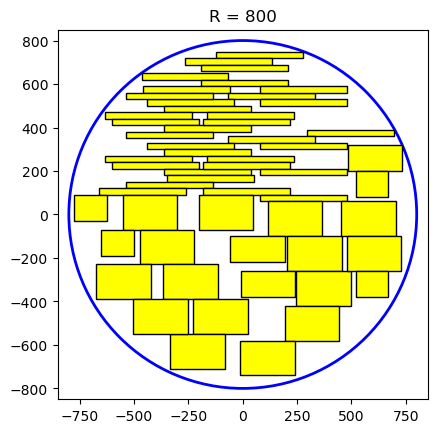

23060.0

In [484]:
ea.visualize()
ea.fitness()

#### 850

In [464]:
r850 = pd.read_csv("cutting/r850.csv", header=None)

In [465]:
ea2 = EA(r850, 850)
ea2.initialize()

DESK 0
Rectangle 1 placed: -112.45435406086301 700.0 450 80
Rectangle 2 placed: -523.1663257860641 589.0 450 80
Rectangle 3 placed: 274.2745120030486 364.0 450 80
Rectangle 4 placed: 193.97224008465173 474.0 450 80
Rectangle 5 placed: -216.48058636670635 394.0 450 80
Rectangle 6 placed: -28.43768222683832 620.0 450 80
Rectangle 7 placed: -736.2706682032141 344.0 450 80
Rectangle 8 placed: 104.20492197897806 284.0 450 80
Rectangle 9 placed: 367.93592580515747 148.0 450 80
Rectangle 10 placed: -573.004226530059 509.0 450 80
Rectangle 11 placed: -164.26959494265668 204.0 450 80
Rectangle 12 placed: -110.77740808991064 124.0 450 80
Rectangle 13 placed: -629.4163946244718 264.0 450 80
Rectangle 14 placed: -592.089092557729 124.0 450 80
Rectangle 15 placed: -258.35501908812694 44.0 450 80
Rectangle 16 placed: -349.6602215409981 -36.0 450 80
Rectangle 17 placed: -644.5720414433667 -116.0 450 80
Rectangle 18 placed: 273.66926181657664 44.0 450 80
Rectangle 19 placed: -197.45881613130405 -196.0

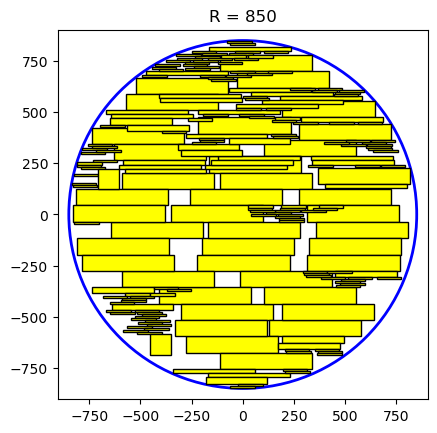

Value: 495150.0


In [466]:
ea2.visualize()
print(f"Value: {ea2.fitness()}")

#### 1000

In [491]:
r1000 = pd.read_csv("cutting/r1000.csv", header=None)

In [492]:
ea3 = EA(r1000, 1000)
ea3.initialize(n_retries=120)

DESK 0
DESK 1
DESK 2
DESK 3


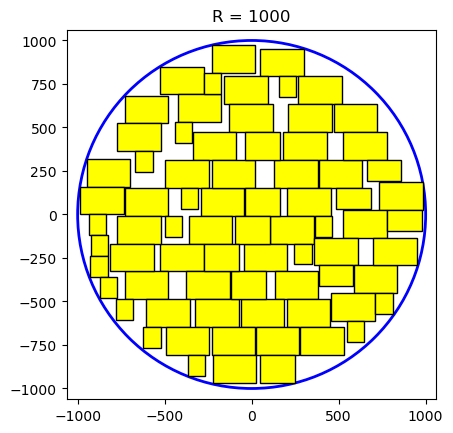

Value: 26780.0


In [493]:
ea3.visualize()
print(f"Value: {ea3.fitness()}")

#### 1100

In [485]:
r1100 = pd.read_csv("cutting/r1100.csv", header=None)

In [486]:
ea4 = EA(r1100, 1100)
ea4.initialize(n_retries=100)

DESK 0
DESK 1
DESK 2
DESK 3


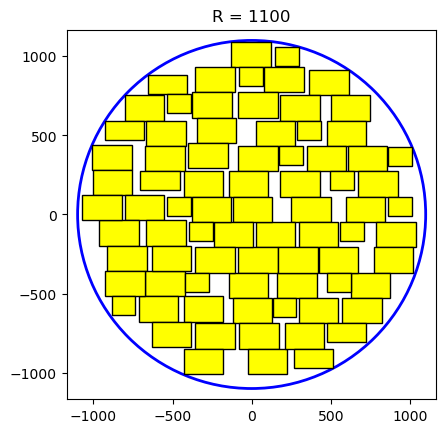

Value: 36500.0


In [487]:
ea4.visualize()
print(f"Value: {ea4.fitness()}")

#### 1200

In [488]:
r1200 = pd.read_csv("cutting/r1200.csv", header=None)

In [489]:
ea5 = EA(r1200, 1200)
ea5.initialize(n_retries=100)

DESK 0
DESK 1
DESK 2
DESK 3


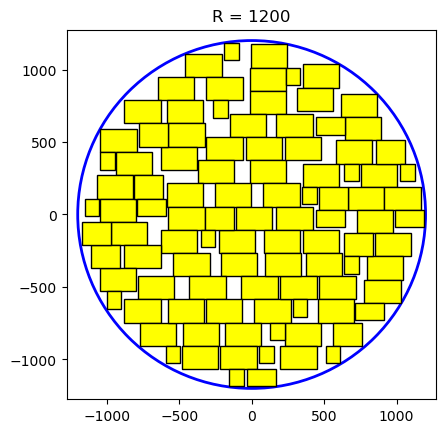

Value: 38580.0


In [490]:
ea5.visualize()
print(f"Value: {ea5.fitness()}")